In [1]:
import copy
import pylab
import random
import numpy as np
from environment import Env # Custom environment
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-10-27 17:41:30.323465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730065290.342256 3777766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730065290.348471 3777766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 17:41:30.369936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DeepSALSA Network
class DeepSARSA(tf.keras.Model):
    def __init__(self, action_size):
        super(DeepSARSA, self).__init__()
        self.fc1 = Dense(30, activation='relu')
        self.fc2 = Dense(30, activation='relu')
        self.fc_out = Dense(action_size)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# DeepSALSA Agent
class DeepSARSAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # hyperparams
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = DeepSARSA(self.action_size)
        self.optimizer = Adam(learning_rate=self.learning_rate)
    
    # Behavior Policy: epsilon greedy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model(state)
            return np.argmax(q_values[0])
    
    # Train (update model)
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay # annealing
        
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            #tape.watch(model_params)
            predict = self.model(state)[0]
            one_hot_action = tf.one_hot([action], self.action_size)
            predict_q_value = tf.reduce_sum(one_hot_action * predict, axis=1)
            
            # if done = True, no next state
            next_q = self.model(next_state)[0][next_action]
            target = reward + (1 - done) * self.discount_factor * next_q
            
            # MSE
            loss = tf.reduce_mean(tf.square(target - predict_q_value))
            
        # model udpate
        grads = tape.gradient(loss, model_params)
        # Debugging: Check if grads or model_params are empty or contain None
        if grads is None or not grads or any(g is None for g in grads):
            print("Error: Gradients are empty or contain None values.")
            print("Loss:", loss)
            print("Model Parameters:", model_params)
            print("Gradients:", grads)
            return  # Exit early to avoid the apply_gradients error

        if not model_params:
            print("Error: Model parameters are empty.")
            return  # Exit early if model_params is empty

        # Apply gradients
        self.optimizer.apply_gradients(zip(grads, model_params))


I0000 00:00:1730065316.014354 3777766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38487 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
I0000 00:00:1730065316.015990 3777766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38487 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Error: Gradients are empty or contain None values.
Loss: tf.Tensor(0.01934976, shape=(), dtype=float32)
Model Parameters: []
Gradients: []
episode:   0 | score:  -5 | epsilon: 0.993
episode:   1 | score: -29 | epsilon: 0.967
episode:   2 | score:  -6 | epsilon: 0.961
episode:   3 | score:  -1 | epsilon: 0.956
episode:   4 | score: -33 | epsilon: 0.928
episode:   5 | score: -20 | epsilon: 0.907
episode:   6 | score: -20 | epsilon: 0.894
episode:   7 | score:  -4 | epsilon: 0.889
episode:   8 | score:  -2 | epsilon: 0.887
episode:   9 | score:  -9 | epsilon: 0.877
episode:  10 | score:  -3 | epsilon: 0.875
episode:  11 | score: -11 | epsilon: 0.868
episode:  12 | score:  -5 | epsilon: 0.864
episode:  13 | score: -12 | epsilon: 0.852
episode:  14 | score:  -7 | epsilon: 0.844
episode:  15 | score: -32 | epsilon: 0.817
episode:  16 | score:  -9 | epsilon: 0.810
episode:  17 | score: -11 | epsilon: 0.800
episode:  18 | score: -21 | epsilon: 0.784
episode:  19 | score:  -1 | epsilon: 0.781
e

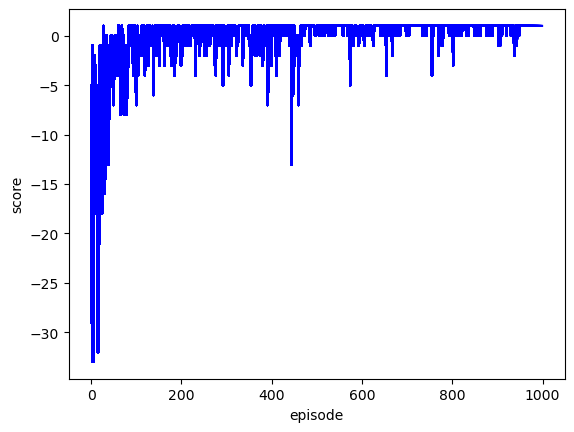

In [3]:
if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env(render_speed=0.001)
    #env = Env()
    state_size = 15
    action_space = [0, 1, 2, 3, 4]
    action_size = len(action_space)
    agent = DeepSARSAgent(state_size, action_size)

    scores, episodes = [], []

    EPISODES = 1000
    for e in range(EPISODES):
        done = False
        score = 0
        # Initialize env
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            # Choose action from the current state
            action = agent.get_action(state)

            # Take the action and collect new state and reward
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            next_action = agent.get_action(next_state)

            # SARSA (TD with on-policy) Learning
            agent.train_model(state, action, reward, next_state,
                                next_action, done)
            score += reward
            state = next_state

            if done:
                # print out intermediate results
                print("episode: {:3d} | score: {:3d} | epsilon: {:.3f}".format(
                      e, score, agent.epsilon))

                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("score")
                pylab.savefig("./save_graph/graph.png")


        # 100 에피소드마다 모델 저장
        if e % 100 == 0:
            agent.model.save_weights('./checkpoint/model.' + str(e) + '.weights.h5')

In [4]:
e = 1
print("1" + str(e))

11
